# Tutorial 2 - Reti neurali convolutive in TF

**Prerequisiti per il tutorial:**
* [T1 - Reti neurali feedforward](1-Reti-neurali-feedforward.ipynb)

**Contenuti del tutorial:**
1. Concetti base delle reti neurali convolutive.
2. Implementazione di una rete neurale convolutiva in TF.

## Introduzione alle reti convolutive

L'enorme flessibilità delle reti neurali è allo stesso tempo il loro punto di forza ed il loro svantaggio. Consideriamo un problema dove l'input alla rete neurale è un'immagine di 64x64 pixel, in RGB, ad esempio una piccola telecamera che deve imparare a riconoscere la presenza o meno di una determinata persona. Nonostante si tratti di un'immagine molto piccola, in tutto avremmo già 64x64x3 = **12228 input** alla rete neurale, considerando che ciascun pixel è descritto da tre colori diversi. Con soli 10 neuroni nel primo strato nascosto, avremmo oltre **120mila parametri** liberi da adattare per riconoscere un qualche oggetto nell'immagine.

Le **reti neurali convolutive** (convolutional neural network, CNN) sono un modo di risolvere questo problema quando, come nel caso delle immagini, l'input alla rete neurale presenta una forma di *località* dell'informazione. In questo caso, ciascun neurone nello strato nascosto viene sostituito da un filtro di dimensioni fisse (es., 5x5x3), che viene fatto scorrere sull'intera immagine per ottenere la sua uscita:

![Esempio di filtro convolutivo](./images/Convolution_schematic.gif)
http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/

Uno **strato convolutivo** si ottiene facendo scorrere in parallelo diversi filtri di questo tipo sull'immagine, a cui viene fatta seguire una nonlinearità come in una rete neurale tradizionale. 

Considerando di nuovo il caso dell'immagine di prima, con 10 filtri di questo tipo si otterrebbero 5x5x3x10 = **750 parametri adattabili**, una riduzione di oltre 100 volte. Questa architettura è enormemente popolare per le immagini, ed ha trovato applicazioni di recente anche per l'[audio](https://deepmind.com/blog/wavenet-generative-model-raw-audio/) e problemi di [processamento del linguaggio](http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/); entrambi situazioni dove le convoluzioni, a differenza che nella figura sopra, sono mono-dimensionali.

In pratica, una CNN si costruisce interponendo a questi strati convolutivi altri strati, come nella figura sotto:

![Esempio di rete convolutiva](https://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/11/Screen-Shot-2015-11-07-at-7.26.20-AM.png)
http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/

Gli strati di **pooling** servono ad effettuare un sottocampionamento dell'uscita dello strato precedente, ad esempio prendendo il massimo valore in delle regioni 2x2 o 3x3. Nella parte finale della rete, vengono tipicamente aggiunti strati interamente connessi (come nelle reti neurali standard), prima di procedere alla classificazione. Questi sono solo gli elementi di base delle reti convolutive; vedremo alcuni concetti più avanzati, necessari a costruire reti con numerosi strati nascosti, in un prossimo tutorial.

Va notato da subito come, nel caso delle CNN, l'attivazione di un singolo strato è ora descritta da un tensore a *quattro* dimensioni, in quanto l'uscita di ciascun filtro è a sua volta bidimensionale.

## Esempio di classificazione su immagini

Come esempio di problema di classificazione di immagini, utilizziamo il dataset [**Labeled faces in the wild**](http://vis-www.cs.umass.edu/lfw/), una collezione annotata di immagini di numerose celebrità.


<code>scikit-learn</code> mette a disposizione una funzione per scaricare il dataset, oltre 200 MB di dati in questa versione:

In [1]:
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

Nell'esempio prima, abbiamo scelto di scaricare solo le immagini di persone di cui abbiamo (almeno) 70 esempi, le quali sono soltanto 6:

In [2]:
lfw_people.target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], 
      dtype='<U17')

Per semplicità, consideriamo qui un problema di classificazione binaria per distinguire fra le foto di Colin Powell (236 foto) e le foto di Tony Blair (144 foto):

In [3]:
idx = (lfw_people.target == 1) | (lfw_people.target == 6)
X = lfw_people.images[idx]
y = lfw_people.target[idx]

Sistemiamo il vettore di target in modo che contenga solo 0 od 1:

In [4]:
y[y == 6] = 0
y = y.reshape(-1, 1)

Per comodità di TF, aggiungiamo una dimensione alla matrice di immagini, che rappresenta il singolo canale:

In [5]:
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

Aggiungendo un parametro <code>color=True</code> alla funzione <code>fetch_lfw_people</code> potremmo scaricare i tre canali RGB invece di un singolo canale in scala di grigi. Di tutte le immagini teniamo da parte un 20% per andare a testare la nostra rete neurale:

In [6]:
from sklearn import model_selection
(X_trn, X_tst, y_trn, y_tst) = model_selection.train_test_split(X, y, test_size=0.20)

Vediamo un esempio di immagine di training:

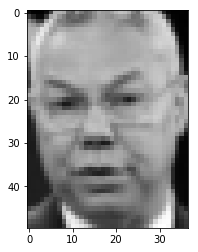

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(X[1,:,:, 0], cmap='gray')

Come si può vedere, ciascuna immagine è 50x37, in bianco e nero:

In [8]:
X[0].shape

(50, 37, 1)

Per finire, rappresentiamo i pixel in [0,1], invece che in [0, 255]:

In [9]:
X /= 255

## Costruiamo la nostra rete convolutiva

Come nello scorso tutorial, cominciamo definendo i nostri placeholder di input e di output:

In [10]:
import tensorflow as tf
X_tf = tf.placeholder(tf.float32, [None, 50, 37, 1], name='input')
y_tf = tf.placeholder(tf.float32, [None, 1], name='target')

Al posto di definire manualmente tutte le variabili e le operazioni della rete, iniziamo ad utilizzare gli strati già definiti nel modulo <code>layers</code>:
https://www.tensorflow.org/api_docs/python/tf/layers/.

Va sottolineato da subito come alcuni di questi strati si appoggiano interiormente a funzioni più semplici definite nel modulo <code>nn</code>, come lo strato per la convoluzione 2D (<code>conv2D</code>):

https://www.tensorflow.org/api_docs/python/tf/layers/conv2d<br />
https://www.tensorflow.org/api_docs/python/tf/nn/conv2d

Questa duplicazione di classi non deve però confondere, in quanto è possibile usare in maniera equivalente ciascuno dei due; le funzioni in <code>nn</code> hanno in genere meno parametri e meno flessibilità, e sono preferibili quando questa flessibilità non è richiesta.

Per uniformità, in questo tutorial useremo solo le funzioni definite nel modulo <code>layers</code>. La nostra rete sarà così composta:

* Uno strato convolutivo, con 64 filtri 5x5.
* Uno strato di pooling 2x2.
* Un secondo strato convolutivo, con 32 filtri 5x5.
* Un secondo strato di pooling 2x2.
* Uno strato interamente connesso con 20 neuroni.
* Un neurone di uscita con la classe desiderata.

Questa non è ovviamente l'unica scelta, né tantomeno la migliore, il che richiederebbe un'ottimizzazione più completa di tutto il design della rete (si veda ad esempio [questo articolo](https://arxiv.org/abs/1611.00847)). Questo genere di alternanza di strati convolutivi e pooling, di dimensioni sempre più piccole, e seguito da strati densamente connessi è però tipico nella maggior parte delle applicazioni con reti non molto grandi. Considereremo il design di reti più complesse e la loro ottimizzazione in tutorial successivi; va detto da subito, comunque, che spesso questa fase di costruzione è più un unirsi di esperienza ed 'arte', piuttosto che il susseguirsi di regole precise.

Iniziamo definendo il primo strato convolutivo:

In [11]:
conv1 = tf.layers.conv2d(X_tf, 64, (5,5), activation=tf.nn.relu, name='conv1')

Andiamo a valutare la dimensione del tensore di uscita:

In [12]:
conv1.shape

TensorShape([Dimension(None), Dimension(46), Dimension(33), Dimension(64)])

Come sempre, la prima dimensione rappresenta un mini-batch di attivazioni. Il resto del tensore è quindi costituito da 64 filtri, ciascuno 46x33. Si noti la leggera discrepanza con la dimensione delle immagini di ingresso: poiché la convoluzione non è definita sui bordi dell'immagine, perdiamo 2 pixel in ogni dimensione. Possiamo ovviare a questo problema aggiungendo del padding di zeri sui bordi dell'immagine originale:

In [13]:
# conv1 = tf.layers.conv2d(X_tf, 64, (5,5), padding='same', name='conv1')

Continuiamo aggiungendo lo strato di pooling, questa volta considerando il padding:

In [14]:
pool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same', name='pool1')

Il terzo parametro rappresenta lo **stride**, ovvero ogni quanti pixel calcoliamo un risultato. Con questa configurazione, abbiamo effettivamente dimezzato la dimensione dei tensori: 

In [15]:
pool1.shape

TensorShape([Dimension(None), Dimension(23), Dimension(17), Dimension(64)])

Continuiamo con tutti gli strati rimanenti:

In [16]:
conv2 = tf.layers.conv2d(pool1, 32, (5,5), activation=tf.nn.relu, padding='same', name='conv2')
pool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same', name='pool2')
dense = tf.layers.dense(tf.reshape(pool2, [-1, 12*9*32]), 20, activation=tf.nn.relu, name='dense')

Si noti come, per applicare lo strato interamente connesso, è necessario eseguire un reshape del tensore di ingresso, in modo che ogni input sia 1D. Concludiamo con l'ultimo strato con un'attivazione sigmoide:

In [17]:
output = tf.layers.dense(dense, 1, activation=None, name='output')
output_sigmoid = tf.nn.sigmoid(output)

## Allenare la rete convolutiva

La fase di allenamento è sostanzialmente uguale allo scorso tutorial. In particolare, definiamo una funzione per estrarre mini-batch casuali dalle nostre immagini di training:

In [18]:
def iterate_minibatches(X, y, batchsize):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_idx in range(0, len(X) - batchsize + 1, batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
        yield X[excerpt], y[excerpt]

Definiamo una funzione costo:

In [19]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_tf, logits=output))

Inizializziamo un algoritmo di ottimizzazione:

In [20]:
train_step = tf.train.AdagradOptimizer(learning_rate=0.01).minimize(loss)

Per valutare l'accuratezza, definiamo una funzione ausiliaria:

In [21]:
accuracy = tf.reduce_mean(tf.cast(tf.equal(y_tf, tf.round(output_sigmoid)), tf.float32), name='accuracy')

Creiamo una sessione ed inizializziamo tutte le variabili:

In [22]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

Definiamo una dimensione del mini-batch ed un numero di epoche:

In [23]:
epochs = 25
batch_size = 10

Poiché il training potrebbe essere più lento dello scorso tutorial, installiamo un modulo per visualizzare una semplice barra di progresso:

<code>$ pip install tqdm

Minimizziamo la funzione costo, tenendo traccia dell'accuratezza sul test set ad ogni iterazione:

In [24]:
import numpy as np, tqdm
accuracy_history = np.zeros(epochs)
for i in tqdm.tqdm_notebook(range(epochs)):
    accuracy_history[i] = sess.run(accuracy, feed_dict={X_tf: X_tst, y_tf: y_tst})
    print('Current loss is: ', sess.run(loss, feed_dict={X_tf: X_trn, y_tf: y_trn}))
    for xs, ys in iterate_minibatches(X_trn, y_trn, batch_size):
        sess.run(train_step, feed_dict={X_tf: xs, y_tf: ys})

Current loss is:  6.66727
Current loss is:  2.1861
Current loss is:  0.551535
Current loss is:  0.426429
Current loss is:  0.319568
Current loss is:  0.24247
Current loss is:  0.186849
Current loss is:  0.240138
Current loss is:  0.138694
Current loss is:  0.0947196
Current loss is:  0.0959329
Current loss is:  0.055467
Current loss is:  0.0548337
Current loss is:  0.0352569
Current loss is:  0.0356559
Current loss is:  0.0200885
Current loss is:  0.0174607
Current loss is:  0.016162
Current loss is:  0.0123268
Current loss is:  0.010254
Current loss is:  0.00883825
Current loss is:  0.00784905
Current loss is:  0.0073456
Current loss is:  0.00730925
Current loss is:  0.00553962



Visualizziamo l'accuratezza media sul test set:

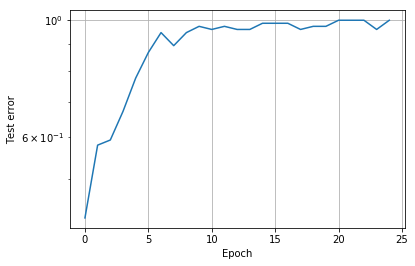

In [25]:
plt.figure()
plt.semilogy(accuracy_history)
plt.xlabel('Epoch')
plt.ylabel('Test error')
plt.grid()

Come si vede, l'accuratezza raggiunge rapidamente il 100%. Se continuassimo il training, o con un dataset meno pulito, ci vorrebbe poco prima di passare però in un regime di **overfitting**. Questo non deve stupire: come detto all'inizio, la flessibilità delle reti neurali è enorme, ed il nostro dataset in questo e molti altri casi è ben lungi dall'essere perfetto. L'overfitting e le tecniche per affrontarlo nelle CNN saranno uno dei protagonisti di un prossimo tutorial.

Prima di rispondere (in parte) a tutte queste domande, ci occuperemo del tema essenziale di **visualizzare** quanto avviene in fase di allenamento.